In [14]:
import cv2
import numpy as np

from pose_vector_to_transformation_matrix import pose_vector_to_transformation_matrix
from project_points import project_points
from undistort_image import undistort_image

In [15]:
# load camera poses
pose_vectors = np.loadtxt('data/poses.txt')

# load camera intrinsics
K = np.loadtxt('data/K.txt')  # calibration matrix[3x3]
D = np.loadtxt('data/D.txt')  # distortion coefficients[2x1]

In [16]:
# calculate the sphere points to then draw the image
offset_x = 0.04 * 4
offset_y = 0.04 * 2 + 0.02
offset_z = -0.04
s = 0.04

step_size = np.pi / 9
cnt_phi = int(2 * np.pi / step_size)
cnt_theta = int(np.pi / step_size) - 1
p_W_sphere = [
    [offset_x, offset_y, offset_z - s, 1],  # north pole
    [offset_x, offset_y, offset_z + s, 1],  # south pole
]
for phi in np.arange(0, 2 * np.pi, step_size):
    for theta in np.arange(step_size, np.pi, step_size):
        p_W_sphere.append(
            [
                offset_x + s * np.sin(theta) * np.cos(phi),
                offset_y + s * np.sin(theta) * np.sin(phi),
                offset_z + s * np.cos(theta),
                1,
            ],
        )
p_W_sphere = np.array(p_W_sphere).reshape(-1, 1, 4)
assert p_W_sphere.shape[0] == cnt_phi * cnt_theta + 2
print(p_W_sphere.shape)

lines_id = []
for i in range(cnt_phi):
    lines_id.append([0, (i + 1) * cnt_theta + 1])  # north pole to last ring
    lines_id.append([1, i * cnt_theta + 2])  # south pole to first ring
    for j in range(cnt_theta - 1):
        idx = i * cnt_theta + j + 2
        lines_id.append([idx, idx + 1])
        idx_nxt = (idx + cnt_theta - 2) % (cnt_phi * cnt_theta) + 2
        lines_id.append([idx, idx_nxt])

# set points in world coordinate
num_pts_per_line = 40
weights = np.linspace(0, 1, num_pts_per_line)[..., None]
p_W_sphere_all = np.zeros((num_pts_per_line * len(lines_id), 4))
for ii, line in enumerate(lines_id):
    indices = slice(ii * num_pts_per_line, (ii + 1) * num_pts_per_line)
    p_W_sphere_all[indices] = (
        weights * p_W_sphere[line[0]] + (1 - weights) * p_W_sphere[line[1]]
    ).reshape(-1, 4)

(146, 1, 4)


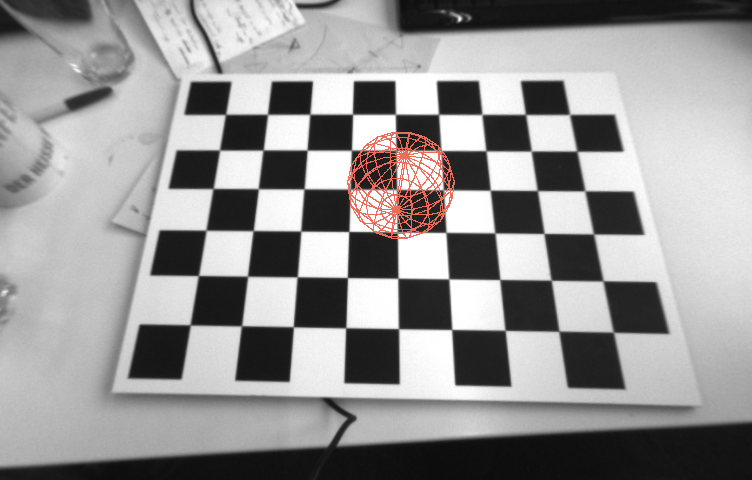

In [20]:
from tqdm.notebook import tqdm
from PIL import Image

images = []

for ii in range(11):
    img_index = ii + 1
    img = cv2.imread("data/images/img_{0:04d}.jpg".format(img_index))

    # undistort image with bilinear interpolation
    img_undistorted = undistort_image(img, K, D, bilinear_interpolation=True)

    # project the corners on the image
    # compute the 4x4 homogeneous transformation matrix that maps points
    # from the world to the camera coordinate frame

    T_C_W = pose_vector_to_transformation_matrix(pose_vectors[ii, :])

    # project on image coordinate
    p_C_sphere = np.matmul(T_C_W[None, :, :], p_W_sphere_all[:, :, None]).squeeze(-1)
    p_C_sphere = p_C_sphere[:, :3]

    sphere_pts = project_points(p_C_sphere, K, np.zeros([4, 1]))
    sphere_pts_int = sphere_pts.astype(int)
    sphere_pts_int = np.unique(sphere_pts_int, axis=0)

    # draw points
    for x, y in sphere_pts_int:
        if (
            0 <= y < img_undistorted.shape[0]
            and 0 <= x < img_undistorted.shape[1]
        ):
            img_undistorted[y, x] = (236, 108, 92)

    images.append(img_undistorted)

Image.fromarray(images[-1])

In [21]:
import warnings

# Save to video file
fps = 20
height, width, _ = images[10].shape
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
video_filename = 'ar_wireframe_sphere.avi'
video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (width, height))

with warnings.catch_warnings(record=True):
    for image in tqdm(images):
        video_writer.write(image)

video_writer.release()

  0%|          | 0/11 [00:00<?, ?it/s]

In [22]:
from matplotlib import animation
from IPython.display import display, HTML

import matplotlib.pyplot as plt

def plot_sequence_images(image_array):
    ''' Display images sequence as an animation in jupyter notebook

    Args:
        image_array(numpy.ndarray): image_array.shape equal to (num_images, height, width, num_channels)
    '''
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[:2]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array), interval=33, repeat_delay=1, repeat=True)
    display(HTML(anim.to_html5_video()))

In [23]:
plot_sequence_images(images)

<Figure size 752x480 with 0 Axes>